In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from src import ContactLens, Simulation, get_parameters, get_curing_time

In [2]:
model = ContactLens()

In [3]:
param = get_parameters()
param2 = get_parameters()
param2.update(
    {
        "Activation energy polimerisation [J.mol-1]": 0,
        "Polimerisation constant": 1.304 * np.exp(-17792 / (8.314 * 353.15)),
    }
)

parameters = [param, param2]

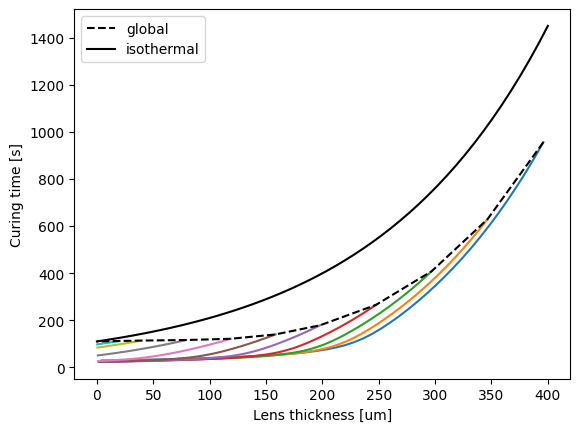

In [6]:
kI = param2["Radiation absorbance [m-1]"]
I0 = param2["UV boundary intensity [W.m-2]"]
q = param2["Polimerisation constant"]
solutions = []
zs = []
t_cs = []
scales = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.25, 1.5, 1.75, 2]
z_end = []
t_c_end = []
for scale in reversed(scales):
    param = get_parameters()
    param["Lens thickness [m]"] *= scale
    sim = Simulation(model, parameter_values=param)
    t = np.linspace(0, 1800, 10000)
    solution = sim.solve(t)
    solutions.append(solution)
    t_c = get_curing_time(solution)
    t_cs.append(t_c)
    zs.append(solution["z [um]"].entries[:, 0])
    z_end.append(solution["z [um]"].entries[-1, -1])
    t_c_end.append(t_c[-1])

z_end += [0]
t_c_end += [- np.log(1 - 0.95) / (I0 ** 0.5 * q)]

for z, t_c, scale in zip(zs, t_cs, scales):
    plt.plot(z, t_c) #, label=f"{scale}")
plt.plot(z_end, t_c_end, "k--", label="global")
plt.plot(np.linspace(0, 400), - np.log(1 - 0.95) / (I0 ** 0.5 * q) * np.exp(0.5 * kI * np.linspace(0, 4e-4)), "k-", label="isothermal")
plt.xlabel("Lens thickness [um]")
plt.ylabel("Curing time [s]")
plt.legend()
plt.savefig("curing_time_vs_L.png", dpi=300)